# Laminar CSD analysis

This tutorial demonstrates how to perform laminar inference using a CSD analysis of event-related source signals. A temporal Gaussian function is simulated at a particular cortical location in various layers. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh, thus providing an estimate of source activity on each layer. A laminar CSD is run on the laminar signals at the location with the peak variance.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import numpy as np
import k3d
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image
import base64

from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.laminar import compute_csd
from lameg.simulate import run_dipole_simulation
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface, color_map, plot_csd, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    f'spm/pspm-converted_autoreject-{subj_id}-{ses_id}-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

The simulations and source reconstructions will be based on a forward model using the multilayer mesh

In [3]:
surf_set = LayerSurfaceSet(subj_id, 15)

verts_per_surf = surf_set.get_vertices_per_layer()

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
28-Oct-2025 16:37:23 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 16:37:23 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           16:37:23 - 28/10/2025
multilayer.15.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-99 100]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 274
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -4.0460e+05
      PostMax: [766365x1 double]
            A: [274x274 double]
           Ip: [1x512 double]
            M: [766365x274 double]
            J: {[766365x4 double]}
            L: [274x766365 double]
           qC: [766365x1 double]
        tempU: [102x102 double]
            V: [102x4 double]
           qV: [120x120 double]
            T: [120x4 double]
            U: {[274x274 double]}
           Is: [1x766365 double]
           It: [1x120 double]
           Ik: [1x60 double]
           Ic: {[1x274 double]}
           Nd: 766365
          pst: [1x120 double]
          dct: [1x102 double]
           ID: 255.0259
            F: -4.0460e+05
           R2: 99.8494
           VE: 56.9085

## Simulating a signal on a superficial surface
We're going to simulate 200ms of a Gaussian with a dipole moment of 5nAm and a width of 25ms

Text(0, 0.5, 'Amplitude (nAm)')

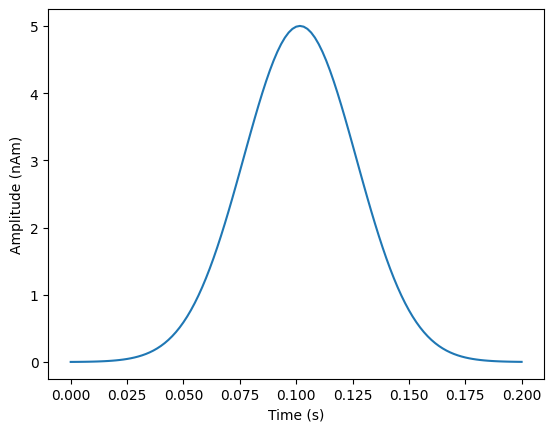

In [6]:
# Strength of simulated activity (nAm)
dipole_moment = 5
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms
# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2)).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [7]:
# Vertex to simulate activity at
sim_vertex=50492

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]
plot = show_surface(
    surf_set,
    marker_vertices=sim_vertex,
    marker_size=5,
    camera_view=cam_view
)

Output()

In [8]:
plot.fetch_screenshot()

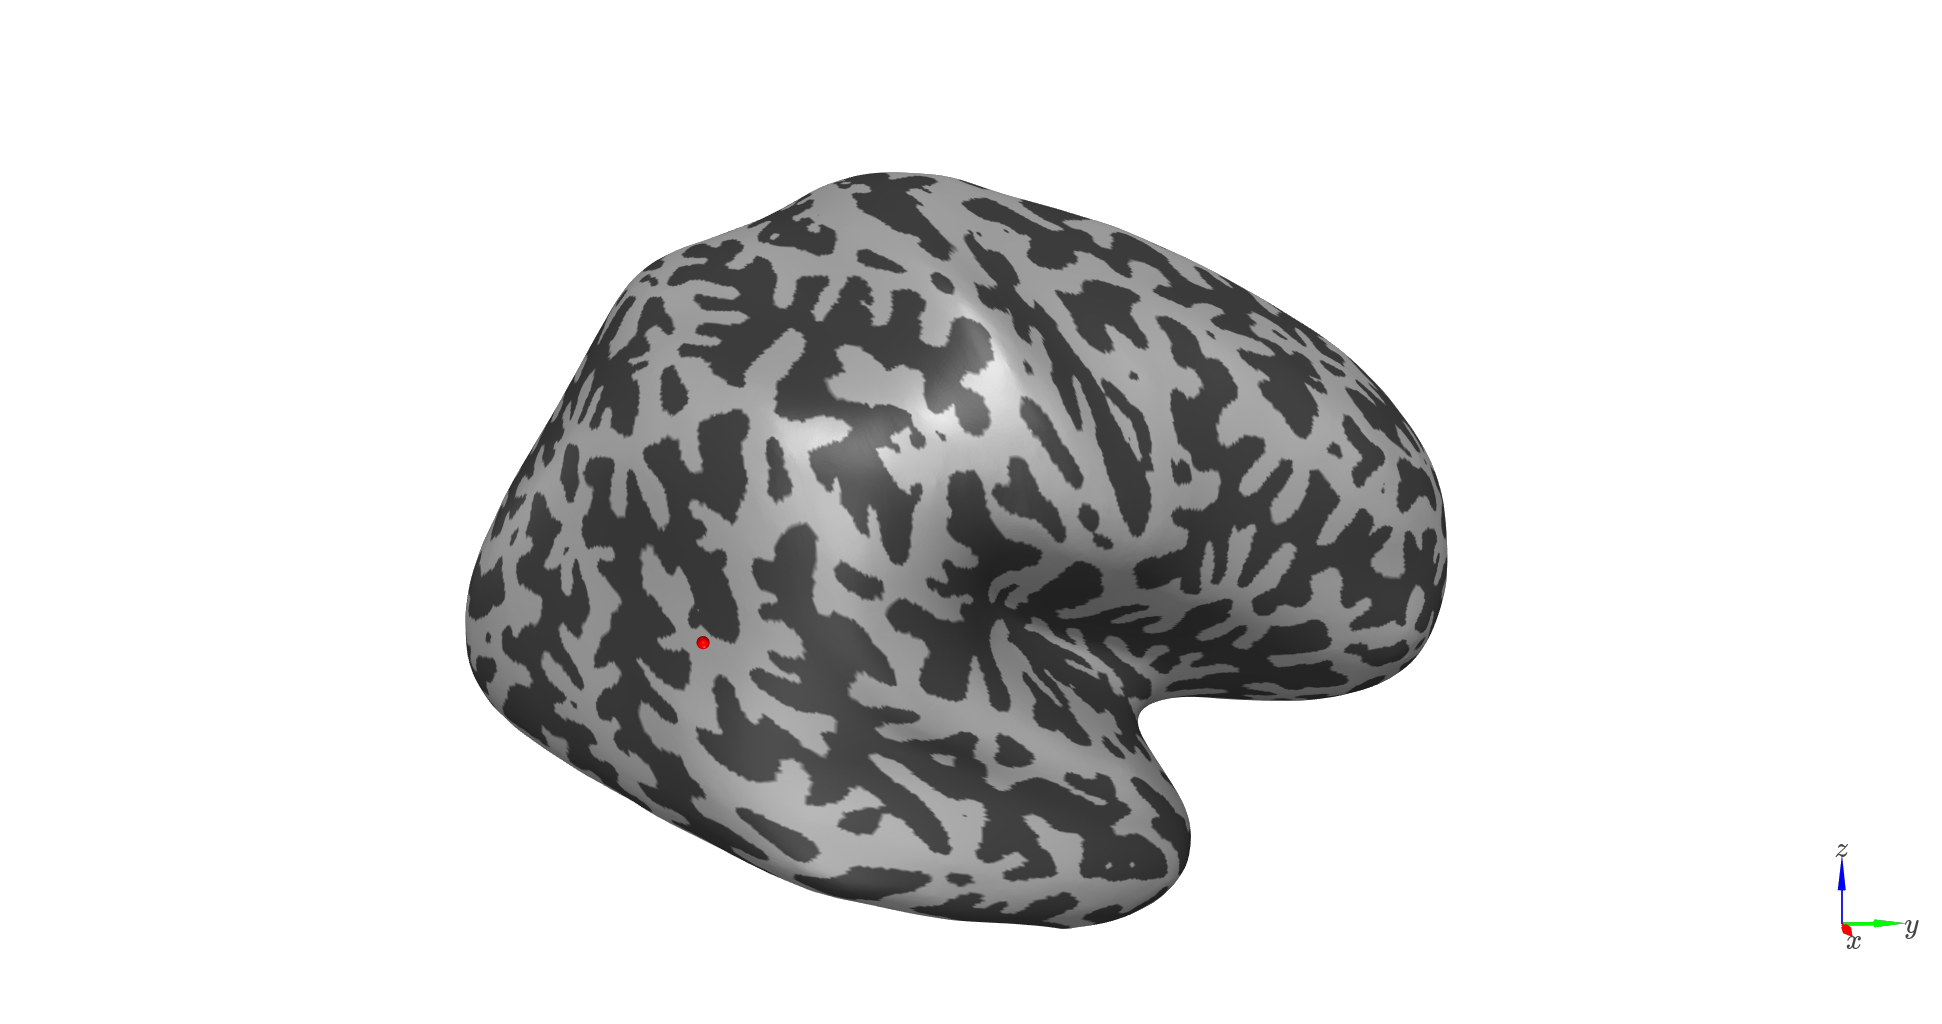

In [9]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [8]:
# Simulate at a vertex on the pial surface
pial_vertex = surf_set.get_multilayer_vertex('pial', sim_vertex)
multilayer_mesh = surf_set.load(stage='ds', orientation='link_vector', fixed=True)
sim_unit_norm = multilayer_mesh.darrays[2].data[pial_vertex,:]
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    sim_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish


## Inversion
Now we'll run a source reconstruction using the multilayer mesh, select the vertex to examine, extract the source signals at each layer in that location, and compute a laminar CSD

In [9]:
[_,_,MU] = invert_ebb(
    pial_sim_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_vertices = np.arange(verts_per_surf)
pial_layer_ts, time, _ = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')

Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmppc4eor3s/sim_50492_pial_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have be

We can see that the peak is very close to the location we simulated at

In [10]:
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

# Plot peak
colors,_ = color_map(
    m_layer_max, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)
thresh_colors=np.ones((colors.shape[0],4))*255
thresh_colors[:,:3]=colors
thresh_colors[m_layer_max<np.percentile(m_layer_max,99.9),3]=0

plot = show_surface(
    surf_set, 
    vertex_colors=thresh_colors, 
    info=True, 
    camera_view=cam_view, 
    marker_vertices=peak, 
    marker_size=5, 
    marker_color=[0,0,255]
)

Output()

51091 vertices


In [13]:
plot.fetch_screenshot()

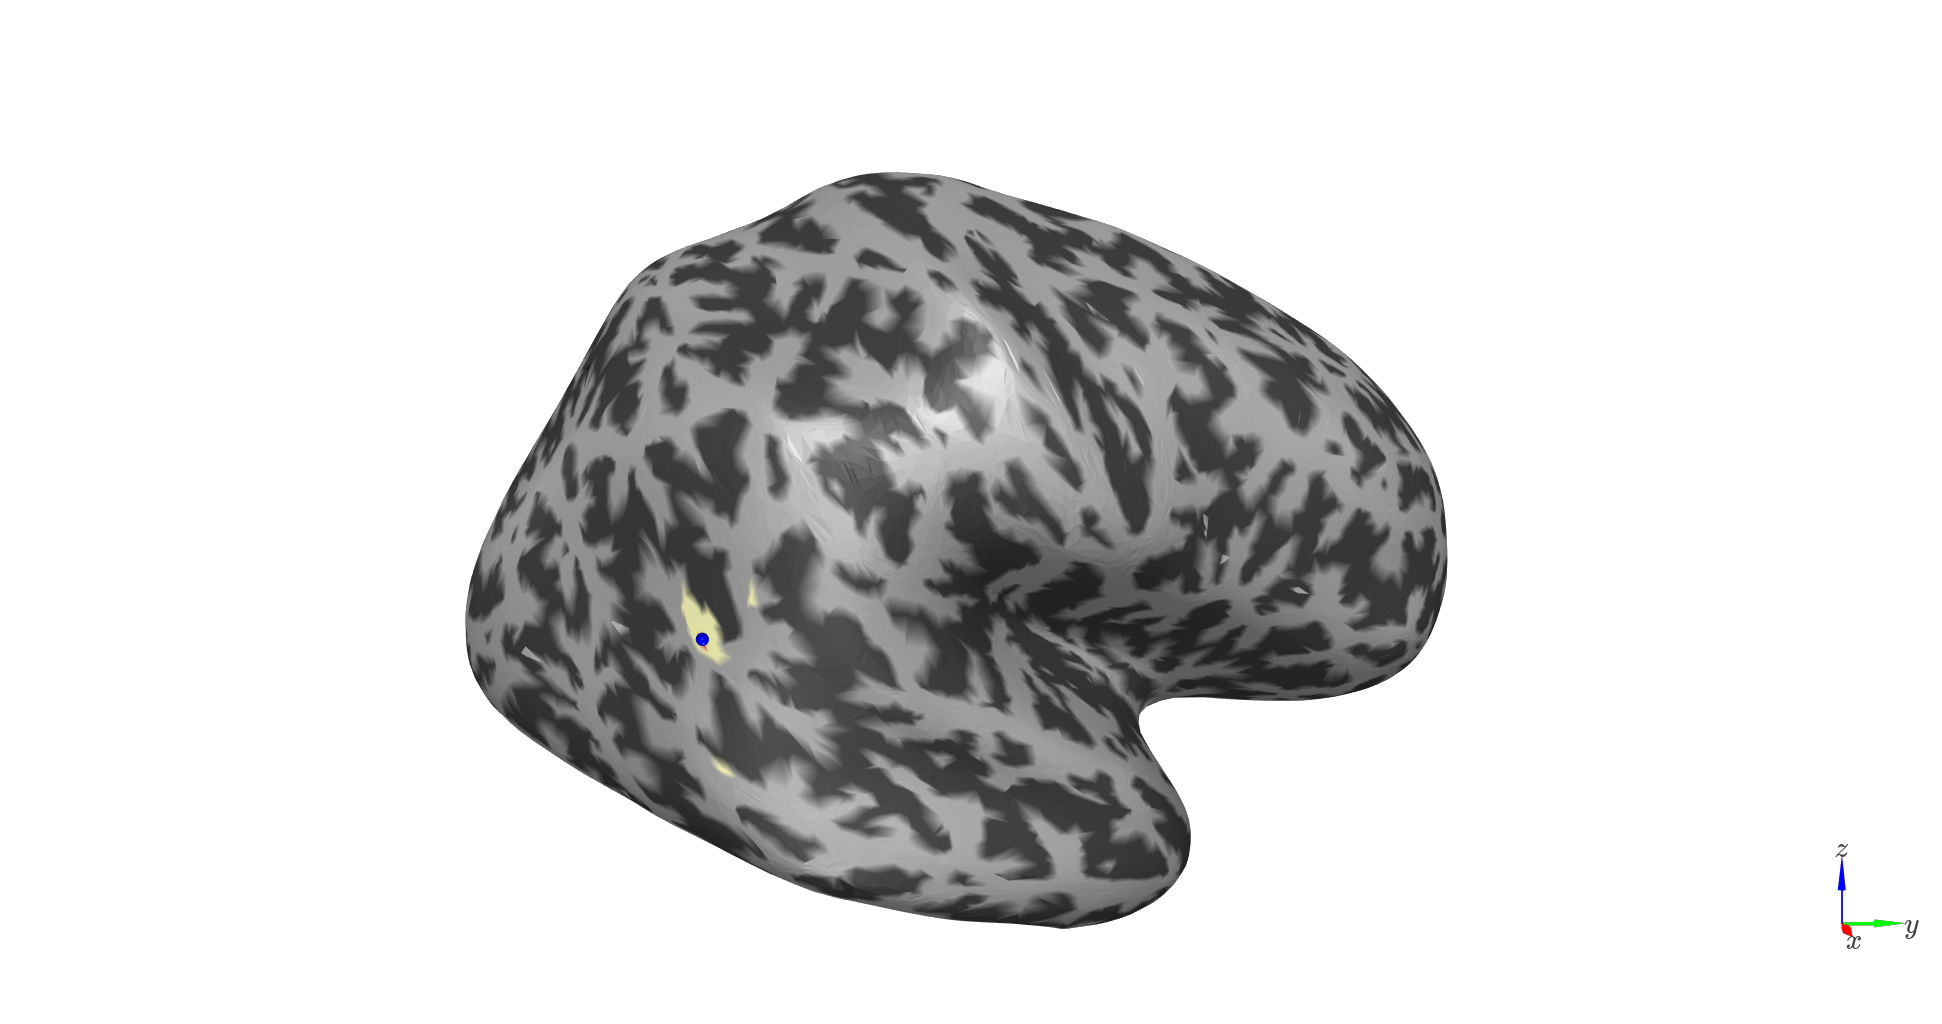

In [14]:
Image(data=base64.b64decode(plot.screenshot))

We need the indices of the vertex at each layer for this location, and the distances between them

In [11]:
layer_verts = [l*int(verts_per_surf)+peak for l in range(surf_set.n_layers)]
layer_coords = multilayer_mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

[0.30533674 0.30079877 0.30079642 0.3007828  0.30078238 0.30077353
 0.30076286 0.3007682  0.3007609  0.3007546  0.30074984 0.30075008
 0.3005197  0.30014312]


Now we can compute and plot the laminar CSD

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


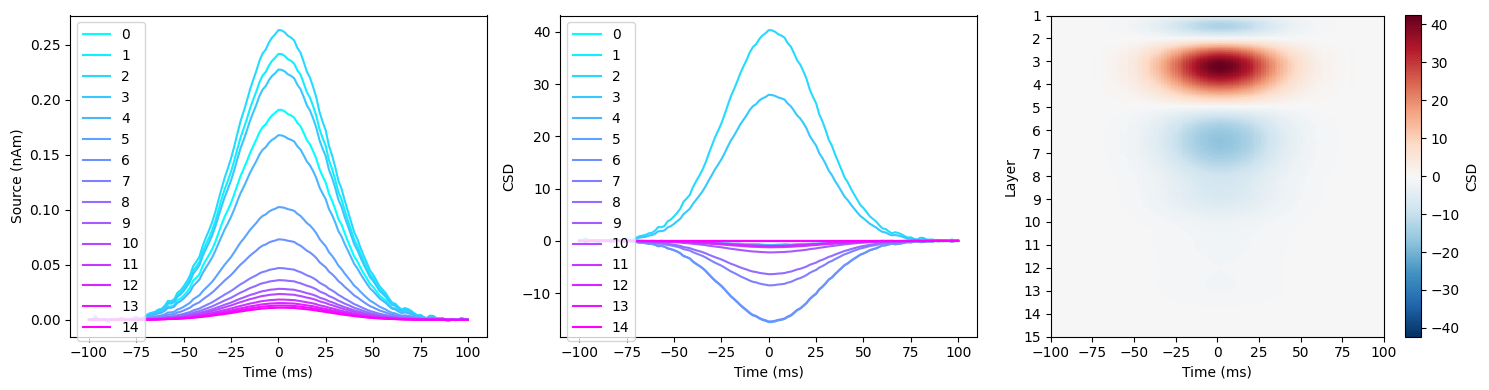

In [12]:
# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(pial_sim_fname, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, np.sum(layer_dists), s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(surf_set.n_layers):
    plt.plot(time, mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(surf_set.n_layers):
    plt.plot(time, csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax, n_layers=surf_set.n_layers)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

## White matter surface simulation with laminar CSD
Let's simulate the same pattern of activity, in the same location, but on the white matter surface.

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish
Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmppc4eor3s/sim_50492_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update

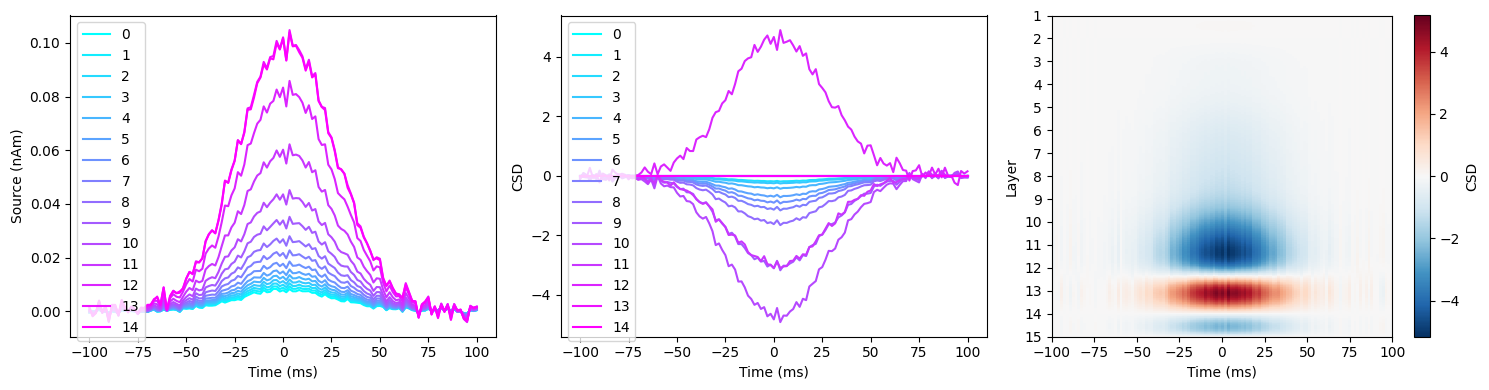

In [13]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = surf_set.get_multilayer_vertex('white', sim_vertex)
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    sim_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)

[_,_,MU] = invert_ebb(
    white_sim_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_ts, time, _ = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')

layer_verts = [l*int(verts_per_surf)+peak for l in range(surf_set.n_layers)]
layer_coords = multilayer_mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(white_sim_fname, mu_matrix=MU, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, np.sum(layer_dists), s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(surf_set.n_layers):
    plt.plot(time, mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(surf_set.n_layers):
    plt.plot(time, csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax, n_layers=surf_set.n_layers)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

## Simulation in each layer
Let's now simulate on each layer, and for each simulation, run the laminar CSD. We'll turn off SPM visualization here.

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish
Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmppc4eor3s/sim_50492_0_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.14729

model evidences relative to maximum:

ans =

     0

28-Oct-2025 18:09:23 - Done    'Source inversion, iterative'
28-Oct-2025 18:09:23 - Done

Simulated vertex=50492, Prior vertex=50266
[0.30533674 0.30079877 0.30079642 0.3007828  0.30078238 0.30077353
 0.30076286 0.3007682  0.3007609  0.3007546  0.30074984 0.30075008
 0.3005197  0.30014312]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish
Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multil

  ReML Iteration 1                      :        ...3.103050e+04 [+4.12]
  ReML Iteration 2                      :        ...2.853943e+04 [+4.25]
  ReML Iteration 3                      :        ...2.358583e+04 [+4.38]
  ReML Iteration 4                      :        ...1.502312e+04 [+4.50]
  ReML Iteration 5                      :        ...5.249915e+03 [+4.62]
  ReML Iteration 6                      :        ...1.765674e+02 [+4.75]
  ReML Iteration 7                      :        ...4.623926e+00 [+4.88]
  ReML Iteration 8                      :        ...3.138567e-01 [+5.00]
  ReML Iteration 9                      :        ...2.385154e-02 [+5.12]
  ReML Iteration 10                     :        ...1.864296e-03 [+5.25]
Percent variance explained 99.98 (70.95)
model evidences relative to maximum:

ans =

     0

28-Oct-2025 18:46:53 - Done    'Source inversion, iterative'
28-Oct-2025 18:46:53 - Done

Simulated vertex=50492, Prior vertex=50492
[0.36706343 0.35010242 0.35006738 0.3500431

  ReML Iteration 1                      :        ...3.102410e+04 [+4.12]
  ReML Iteration 2                      :        ...2.852480e+04 [+4.25]
  ReML Iteration 3                      :        ...2.355254e+04 [+4.38]
  ReML Iteration 4                      :        ...1.496245e+04 [+4.50]
  ReML Iteration 5                      :        ...5.195117e+03 [+4.62]
  ReML Iteration 6                      :        ...1.994084e+02 [+4.75]
  ReML Iteration 7                      :        ...6.020714e+00 [+4.88]
  ReML Iteration 8                      :        ...4.655258e-01 [+5.00]
  ReML Iteration 9                      :        ...4.054595e-02 [+5.12]
  ReML Iteration 10                     :        ...3.644391e-03 [+5.25]
Inverting subject 1
  ReML Iteration 1                      :        ...3.102410e+04 [+4.12]
  ReML Iteration 2                      :        ...2.852480e+04 [+4.25]
  ReML Iteration 3                      :        ...2.355254e+04 [+4.38]
  ReML Iteration 4             

Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.8648    0.5312
    0.9855    0.1352

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 120
Fixed number of temporal modes
Using 4 temporal modes, accounting for 70.52 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.100881e+04 [+4.12]
  ReML Iteration 2                      :        ...2.848111e+04 [+4.25]
  ReML Iteration 3                      :        ...2.344922e+04 [+4.38]
  ReML Iteration 4  

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 21:10:28 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 21:10:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random pa

Setting white noise to give sensor level SNR of -5B

 Finish
Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmppc4eor3s/sim_50492_11_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - ht

model evidences relative to maximum:

ans =

     0

28-Oct-2025 22:53:26 - Done    'Source inversion, iterative'
28-Oct-2025 22:53:26 - Done

Simulated vertex=50492, Prior vertex=50291
[0.31641862 0.307515   0.30749634 0.30748987 0.30747613 0.30747545
 0.3074568  0.30745897 0.30744737 0.3074395  0.30743372 0.30742872
 0.30753464 0.30428523]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
Simulating in layer 13
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish
Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multi

  ReML Iteration 1                      :        ...3.070949e+04 [+4.12]
  ReML Iteration 2                      :        ...2.803286e+04 [+4.25]
  ReML Iteration 3                      :        ...2.291275e+04 [+4.38]
  ReML Iteration 4                      :        ...1.419297e+04 [+4.50]
  ReML Iteration 5                      :        ...4.639301e+03 [+4.62]
  ReML Iteration 6                      :        ...2.809830e+02 [+4.75]
  ReML Iteration 7                      :        ...9.335908e+00 [+4.88]
  ReML Iteration 8                      :        ...8.271420e-01 [+5.00]
  ReML Iteration 9                      :        ...8.326782e-02 [+5.12]
  ReML Iteration 10                     :        ...8.689264e-03 [+5.25]
Percent variance explained 99.97 (69.79)
model evidences relative to maximum:

ans =

     0

29-Oct-2025 00:03:20 - Done    'Source inversion, iterative'
29-Oct-2025 00:03:20 - Done

Simulated vertex=50492, Prior vertex=50266
[0.30533674 0.30079877 0.30079642 0.3007828

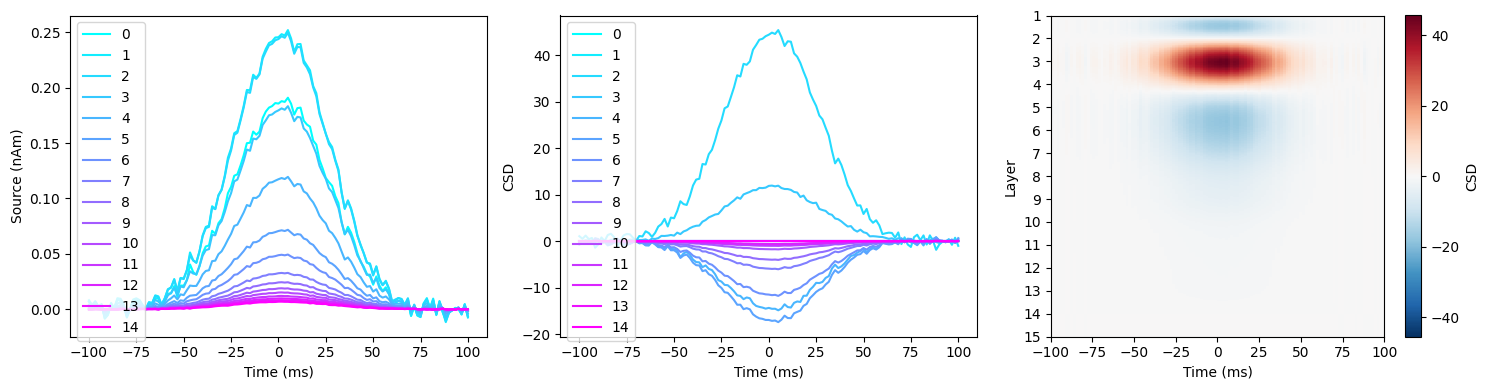

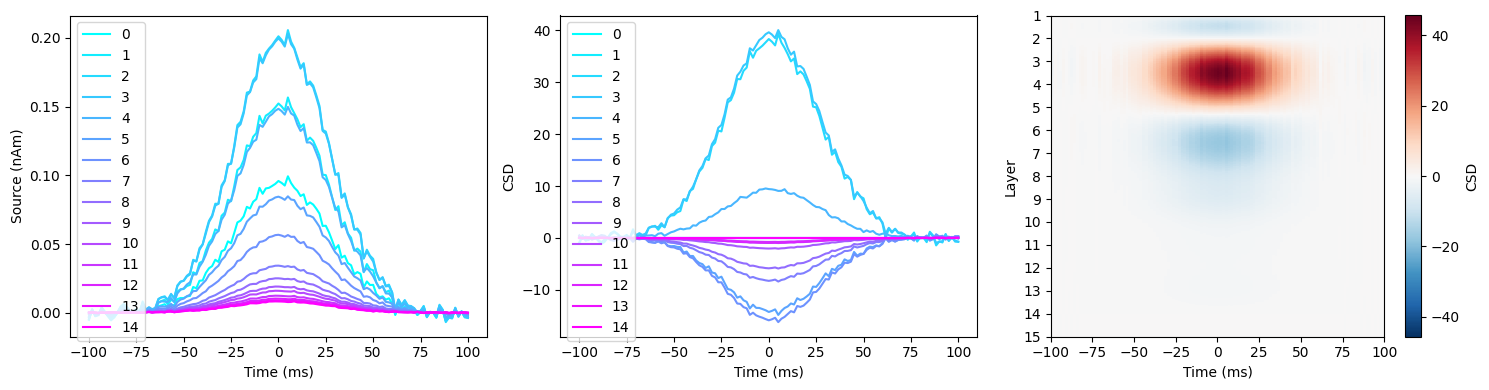

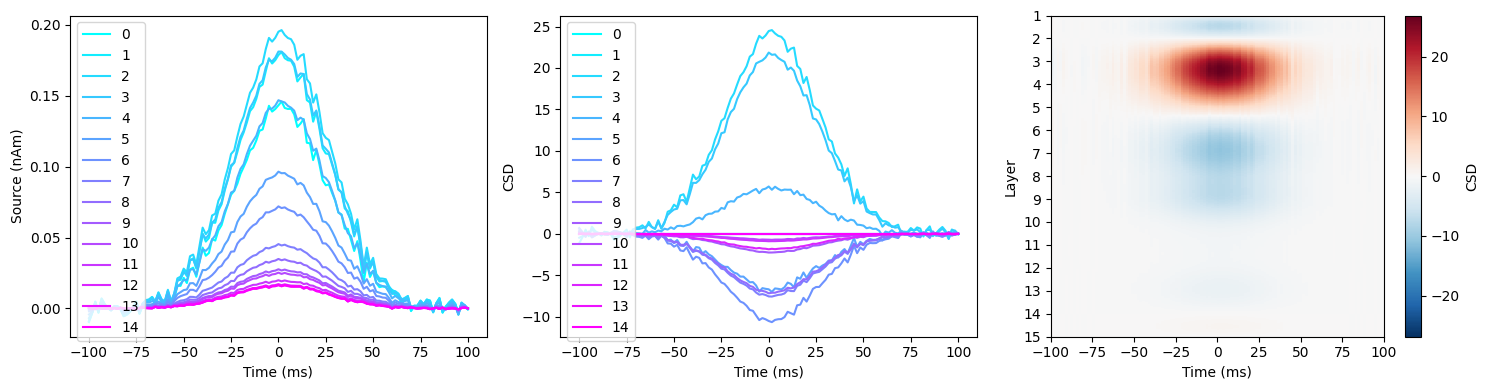

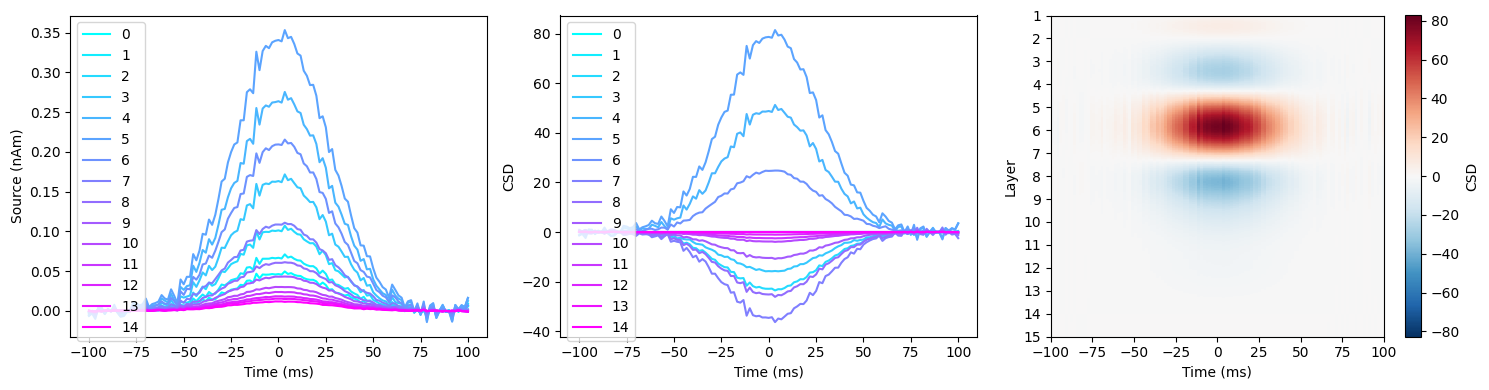

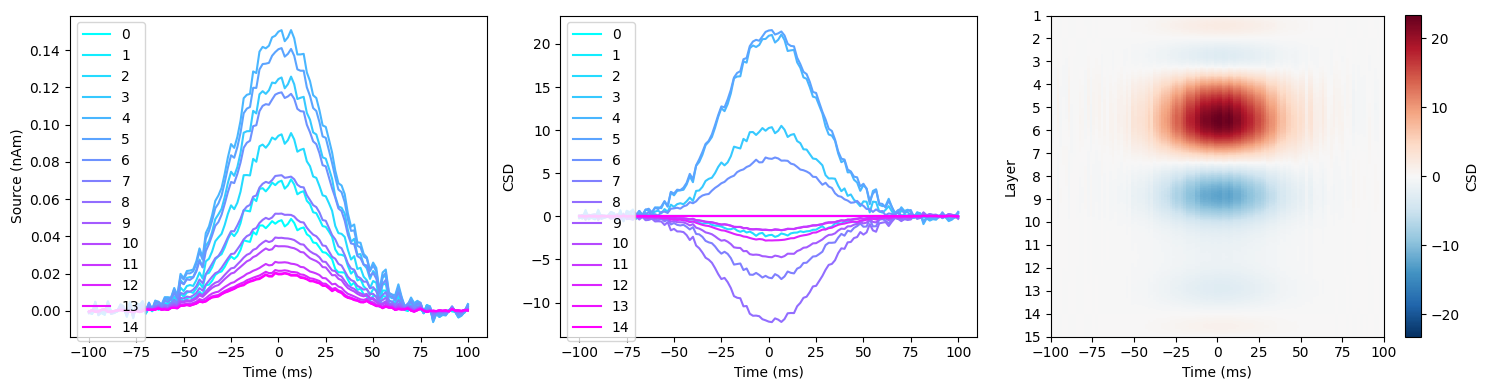

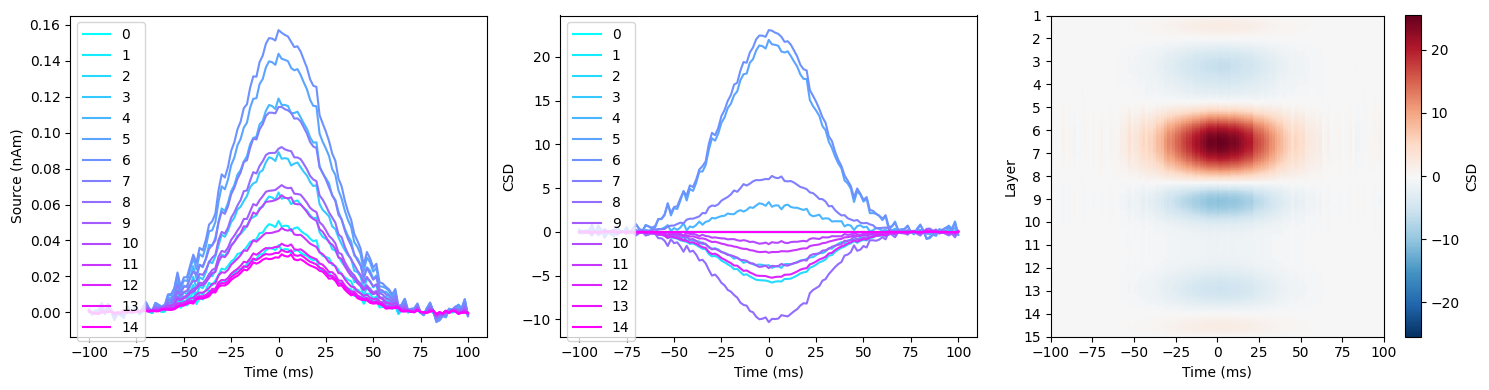

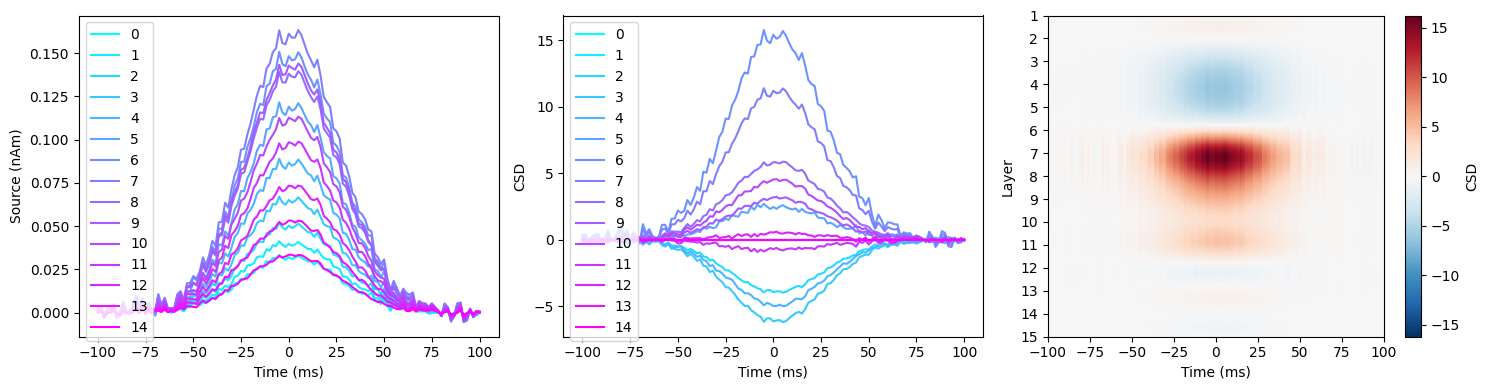

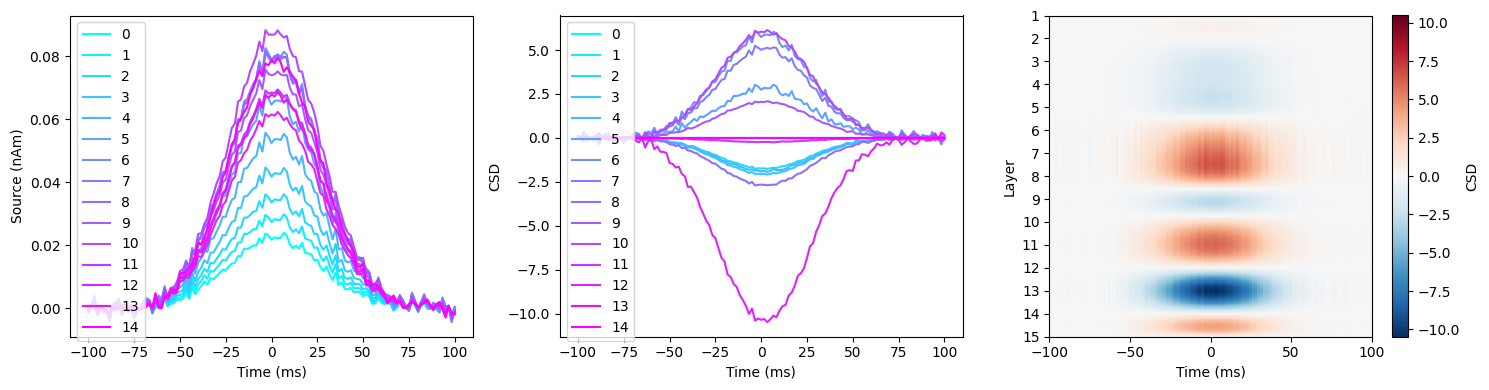

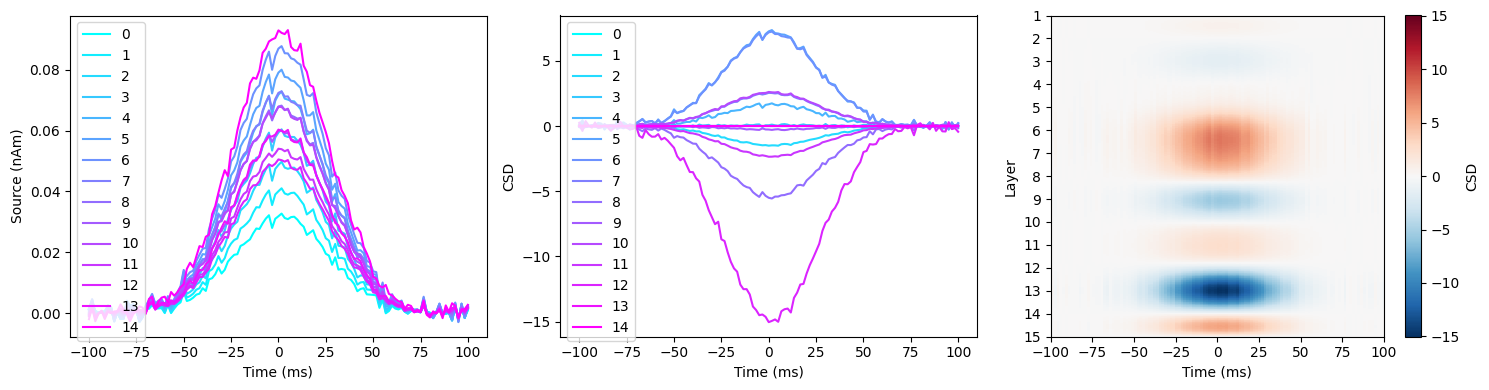

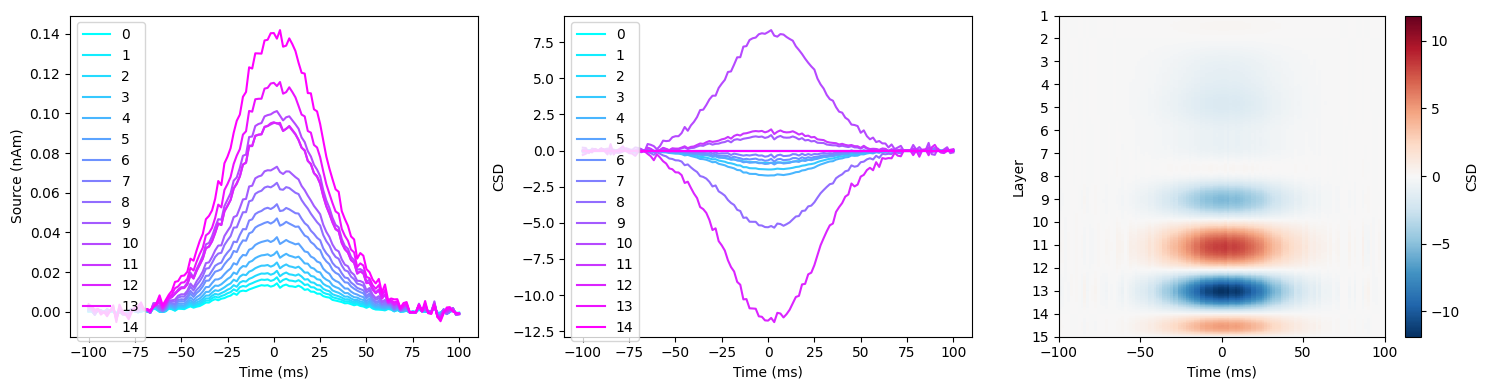

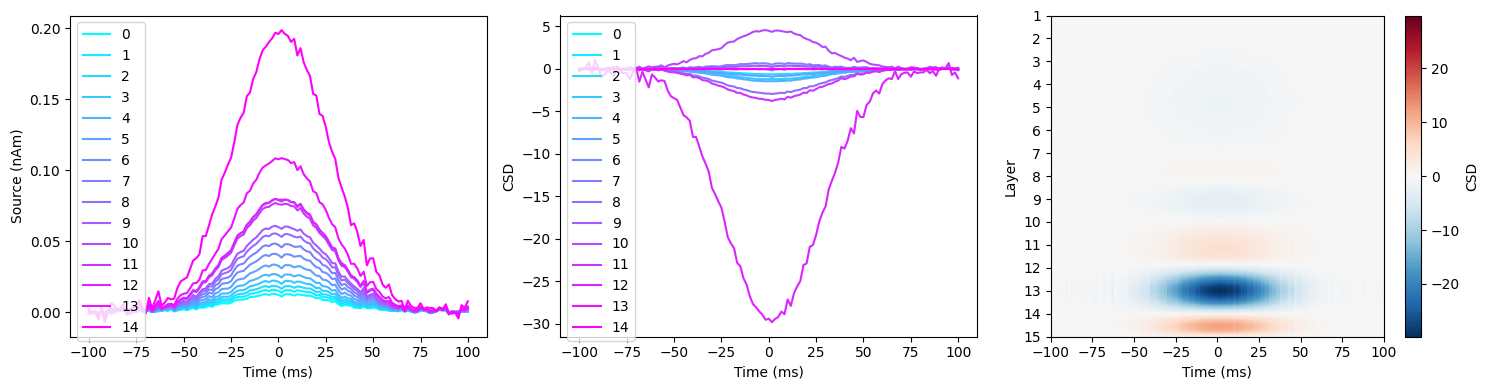

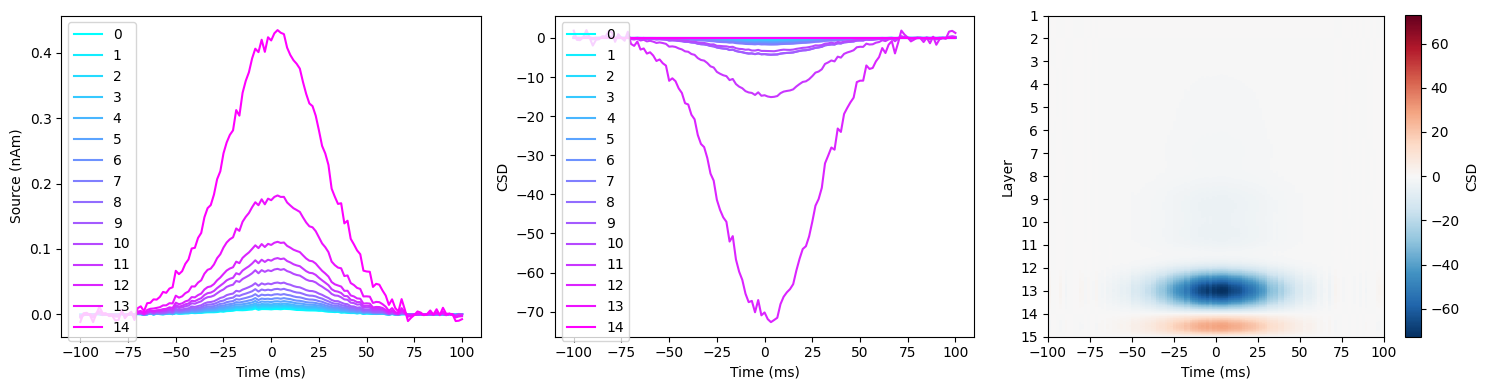

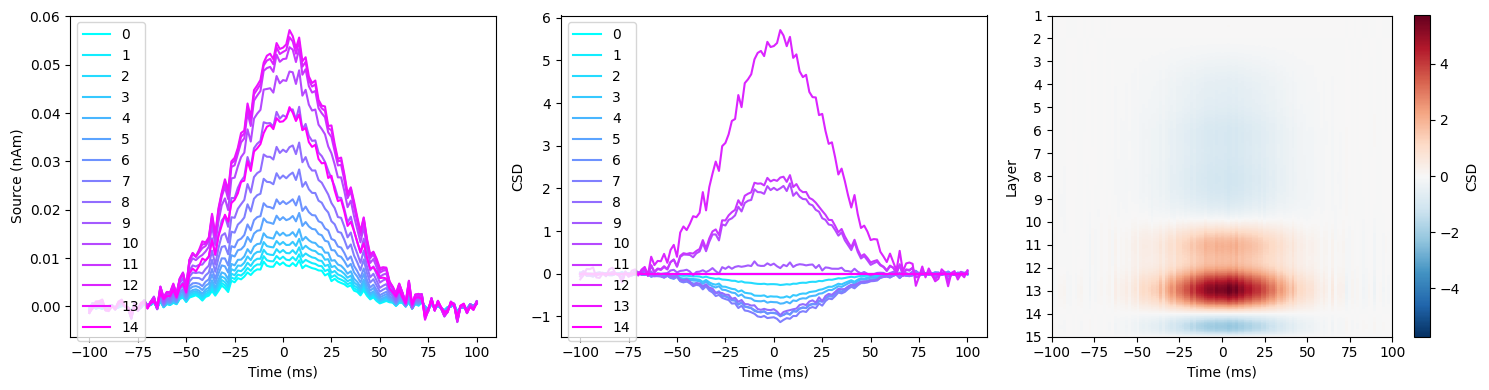

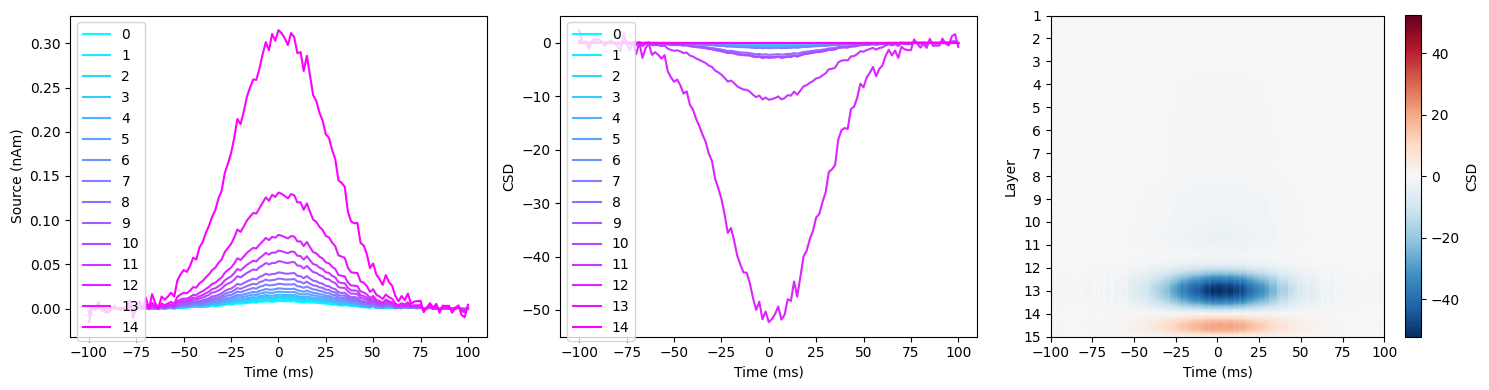

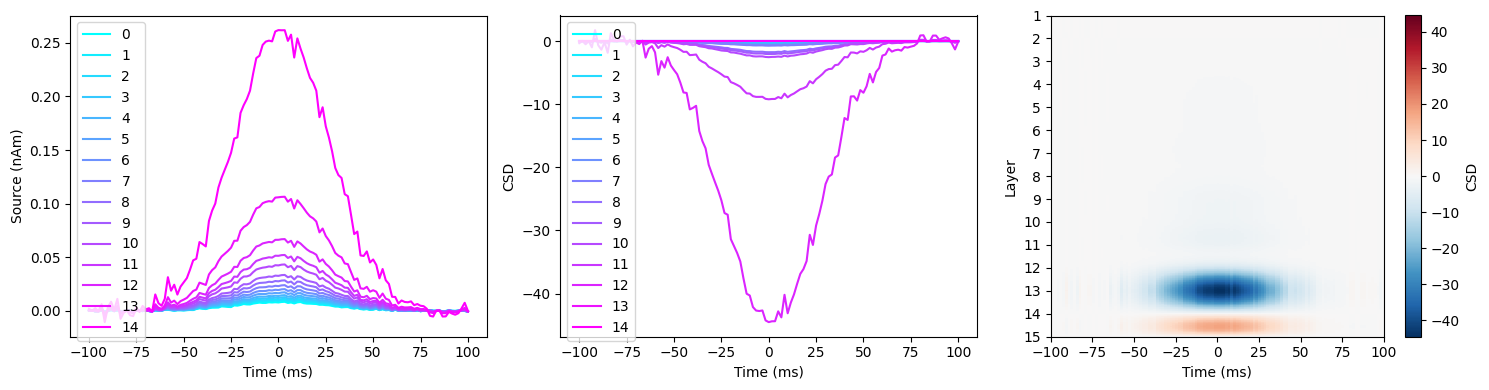

In [14]:
# Now simulate at the corresponding vertex on each layer, and for each simulation compute CSD
layer_csds = []
for l in range(surf_set.n_layers):
    print(f'Simulating in layer {l}')
    prefix = f'sim_{sim_vertex}_{l}_'
    l_vertex = surf_set.get_multilayer_vertex(l, sim_vertex)

    l_sim_fname = run_dipole_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        sim_unit_norm, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    )

    [_,_,MU] = invert_ebb(
        l_sim_fname, 
        surf_set, 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes, 
        viz=False,
        return_mu_matrix=True,
        spm_instance=spm
    )

    pial_layer_ts, time, _ = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=pial_layer_vertices
    )

    # Layer peak
    m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
    peak = np.argmax(m_layer_max)

    print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')
    
    layer_verts = [l*int(verts_per_surf)+peak for l in range(surf_set.n_layers)]
    layer_coords = multilayer_mesh.darrays[0].data[layer_verts,:]
    layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
    print(layer_dists)

    # Get source time series for each layer
    layer_ts, time, _ = load_source_time_series(l_sim_fname, mu_matrix=MU, vertices=layer_verts)

    mean_layer_ts = np.mean(layer_ts,axis=-1)
    [csd, smooth_csd] = compute_csd(mean_layer_ts,np.sum(layer_dists),600,smoothing='cubic')

    col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    for l_idx in range(surf_set.n_layers):
        plt.plot(time, mean_layer_ts[l_idx,:], label=f'{l_idx}', color=col_r[l_idx,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('Source (nAm)')

    plt.subplot(1,3,2)
    for l_idx in range(surf_set.n_layers):
        plt.plot(time, csd[l_idx,:], label=f'{l_idx}', color=col_r[l_idx,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('CSD')

    ax = plt.subplot(1,3,3)
    plot_csd(smooth_csd, time, ax, n_layers=surf_set.n_layers)
    plt.xlabel('Time (ms)')
    plt.ylabel('Layer')
    plt.tight_layout()
    
    layer_csds.append(smooth_csd)        

For each simulation, we can plot a slice of the CSD through layers around a central time window. The layer model where the CSD signal crosses from negative to positive should correspond to the layer that the activity was simulated in.

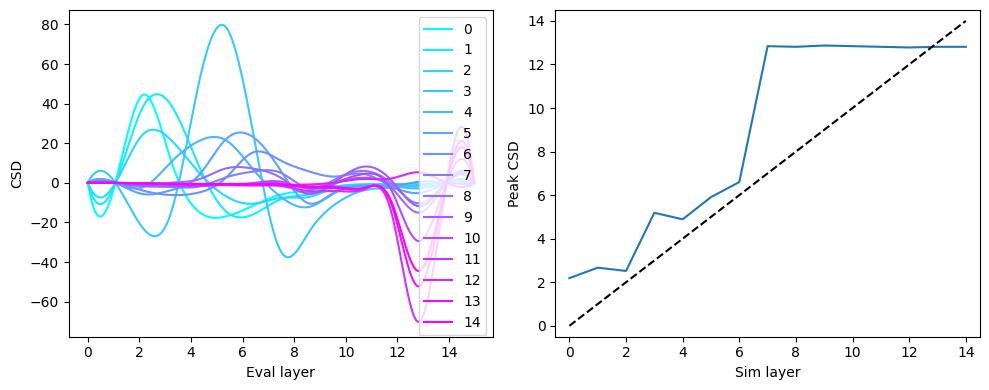

In [15]:
scale_factor=500/surf_set.n_layers
csd_patterns = []
peaks = []
for layer_csd in layer_csds:
    t_idx = np.where((time>=-0.05) & (time<=0.05))[0]
    csd_pattern = np.mean(layer_csd[:,t_idx],axis=1)
    peak = np.argmax(np.abs(csd_pattern))
    #cross_before = np.argmax(0-csd_pattern[:peak]))
    peaks.append(np.argmax(np.abs(csd_pattern))/scale_factor)    
    csd_patterns.append(csd_pattern)

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the CV error of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(surf_set.n_layers):
    plt.plot(np.arange(len(csd_patterns[l]))/scale_factor,csd_patterns[l], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('CSD')

# For each simulation, find which layer model had the lowest CV error
plt.subplot(1,2,2)
plt.plot(np.arange(surf_set.n_layers),peaks)
plt.xlim([-0.5,surf_set.n_layers-.5])
plt.ylim([-0.5,surf_set.n_layers-.5])
plt.plot([0,surf_set.n_layers-1],[0,surf_set.n_layers-1],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak CSD')
plt.tight_layout()

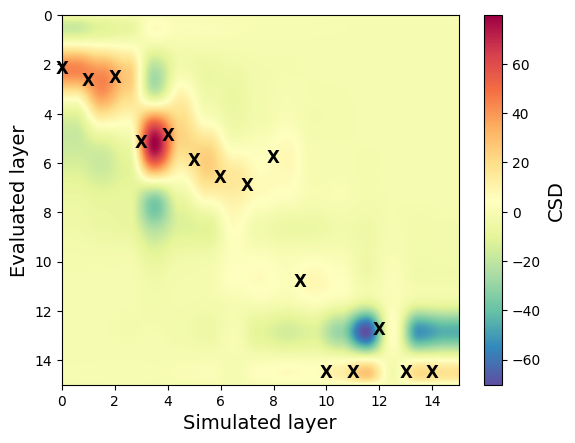

In [16]:
csd_patterns=np.array(csd_patterns)
# Transpose for visualization
im=plt.imshow(csd_patterns.T,aspect='auto', cmap='Spectral_r',extent=[0, surf_set.n_layers, surf_set.n_layers, 0])

# Find the indices of the max value in each column
max_indices = np.argmax(csd_patterns, axis=1)

# Plot an 'X' at the center of the square for each column's maximum
for idx, max_idx in enumerate(max_indices):
    plt.text(idx, max_idx/scale_factor, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

plt.xlabel('Simulated layer', fontsize=14)
plt.ylabel('Evaluated layer', fontsize=14)
cb=plt.colorbar(im)
cb.set_label('CSD', fontsize=14)

## Beta burst CSD
That was a simulation of a source in a single layer. Let's try a beta burst simulation, with simultaneous sources in deep and superficial layers (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

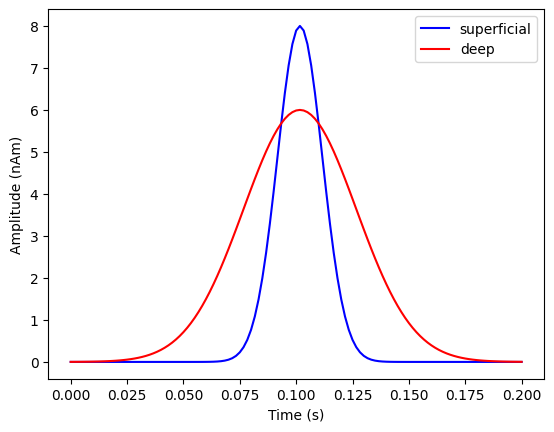

In [17]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

In [18]:
# Location to simulate activity at
sim_vertex=50492
# Corresponding pial and white matter vertices
pial_vertex = surf_set.get_multilayer_vertex('pial', sim_vertex)
white_vertex = surf_set.get_multilayer_vertex('white', sim_vertex)
pial_coord = multilayer_mesh.darrays[0].data[pial_vertex,:]
white_coord = multilayer_mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=multilayer_mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*multilayer_mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))

pial_mesh = surf_set.load(layer_name='pial', stage='combined')
white_mesh = surf_set.load(layer_name='white', stage='combined')

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces, _ = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces, _ = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

Output()

In [19]:
plot.fetch_screenshot()

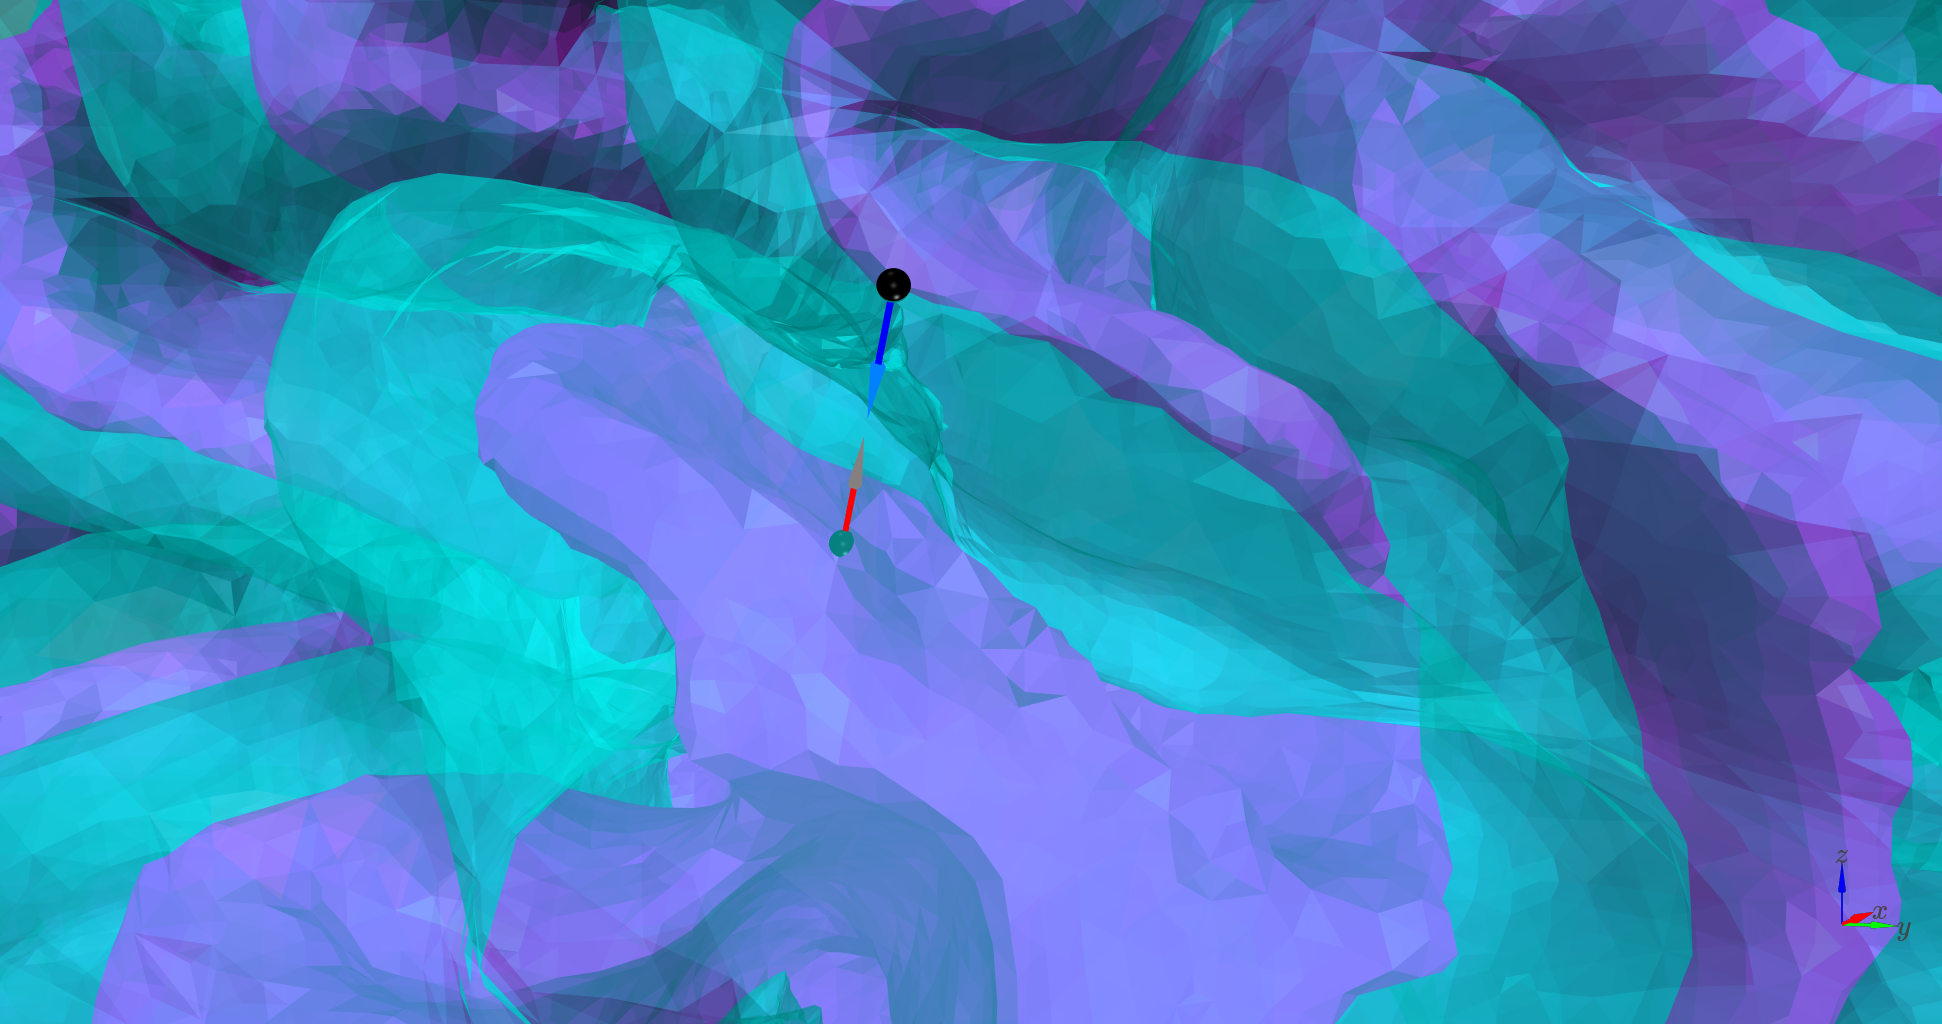

In [20]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [22]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

IdleTimeout has been reached.
Parallel pool using the 'local' profile is shutting down.
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Inversion and CSD
Now we'll run a source reconstruction using the multilayer mesh, select the vertex to examine, extract the source signals at each layer in that location, and compute a laminar CSD

Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.15.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.15.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmppc4eor3s/sim_50492_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have b

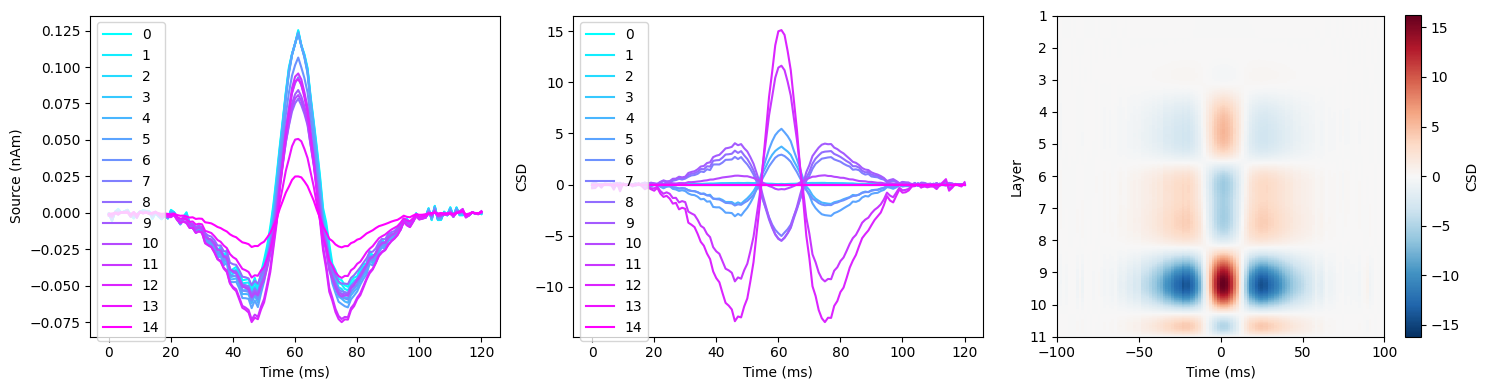

In [23]:
[_,_,MU] = invert_ebb(
    burst_sim_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_vertices = np.arange(verts_per_surf)
pial_layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')

layer_verts = [l*int(verts_per_surf)+peak for l in range(surf_set.n_layers)]
layer_coords = multilayer_mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(burst_sim_fname, mu_matrix=MU, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, np.sum(layer_dists), s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(surf_set.n_layers):
    plt.plot(mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(surf_set.n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [24]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)